In [1]:
# Testing code for DataParser class. 
# Tested roughly each function however, I need to keep in mind that there might be corner cases

# A problematic case occurs when you have no ships or no shipyards. In this case you should not be 

In [3]:
import kaggle_environments
from kaggle_environments import get_episode_replay, list_episodes, list_episodes_for_team, list_episodes_for_submission
import json
from kaggle_environments import *
from kaggle_environments.envs.halite.helpers import *
from .data_parser import DataParser

ImportError: attempted relative import with no known parent package

In [3]:
env = make("halite", debug=True)
env_config = env.configuration
path = "./data/meta/"

training_env = env.train([None, "random", "random", "random"])
obs = training_env.reset()
board = Board(obs, env_config)
# print(board)
data_parser = DataParser()

In [4]:
env.render(mode="ipython", width=400, height=400)

In [5]:
# test individual parser functions and renders
def visualize_obs_for_each_player(board, vers:int=2):
    for i in range(4):  
        player = board.players[i]
        if player.ships != []:
            print(player.ships[0].position)
        raw_map_img, map_img = data_parser.get_player_map(board, i, pad=True)
        ships_obs_img = data_parser.get_player_entity_obs(board, raw_map_img, i, entity="ship",pad=True)
        shipyards_obs_img = data_parser.get_player_entity_obs(board, raw_map_img, i, entity="shipyard", pad=True)
        
        print(f'Player:{i} raw map view')
        data_parser.render_map(data_parser.normalize_board_img(
            data_parser.rotate_board_img(raw_map_img)),i)
        data_parser.render_map(map_img, i)
        
        ship_names = board.players[i].ship_ids
        shipyard_names = board.players[i].shipyard_ids
        print(f'Player:{i} ship names: {ship_names}')
        print(f'Player:{i} shipyard names: {shipyard_names}')
        
        if vers == 1:
            data_parser.render_ship_obs(ship_names, ships_obs_img, i)
            data_parser.render_shipyard_obs(shipyard_names, shipyards_obs_img, i)
        else: 
            data_parser.render_map(ships_obs_img, i)
            data_parser.render_map(shipyards_obs_img, i)

(5, 15)
Player:0 raw map view


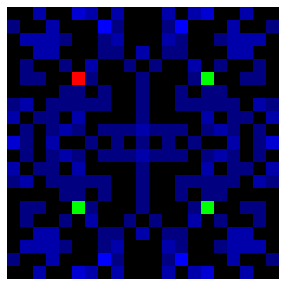

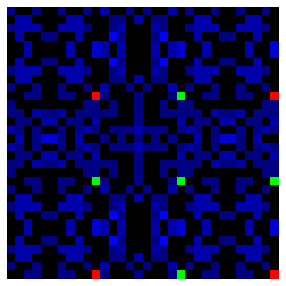

Player:0 ship names: ['0-1']
Player:0 shipyard names: []


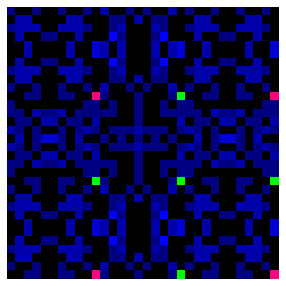

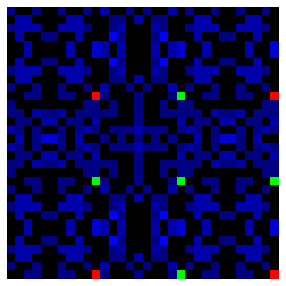

(15, 15)
Player:1 raw map view


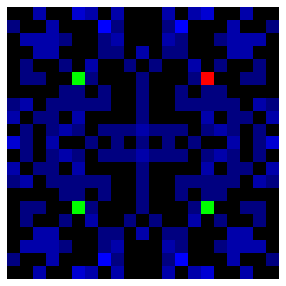

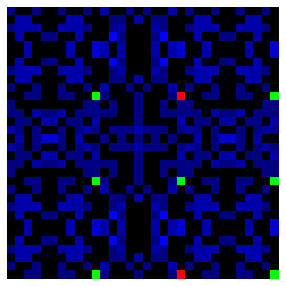

Player:1 ship names: ['0-2']
Player:1 shipyard names: []


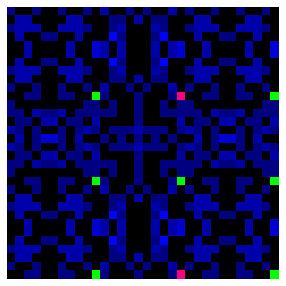

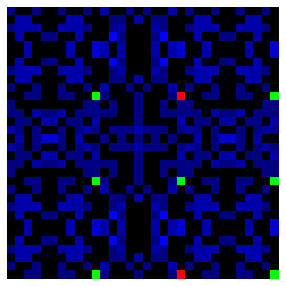

(5, 5)
Player:2 raw map view


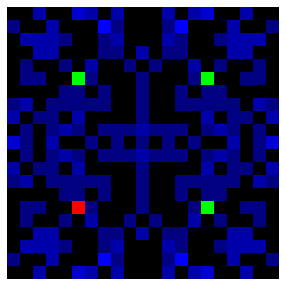

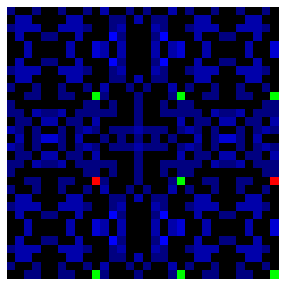

Player:2 ship names: ['0-3']
Player:2 shipyard names: []


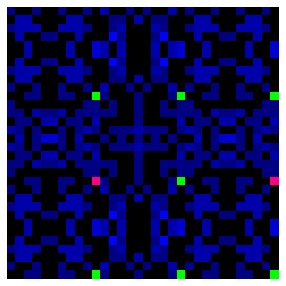

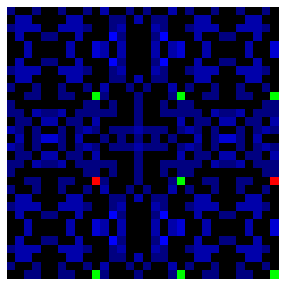

(15, 5)
Player:3 raw map view


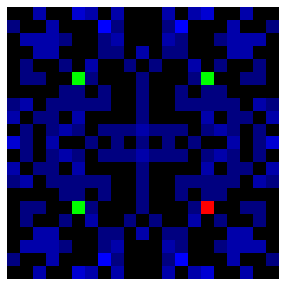

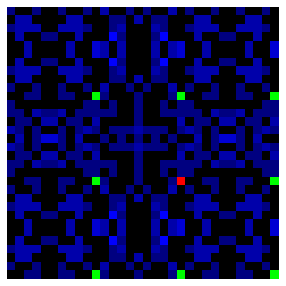

Player:3 ship names: ['0-4']
Player:3 shipyard names: []


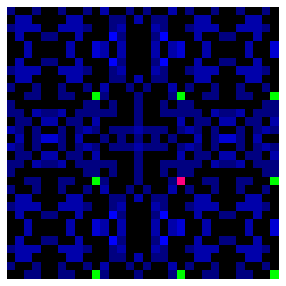

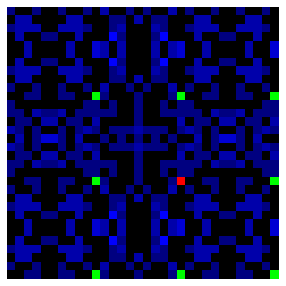

In [6]:
# visualize initial broard state
visualize_obs_for_each_player(board)

In [7]:
from numpy.random import choice

def test_agent(obs, config):    
    halite, shipyards, ships = obs['players'][obs['player']]
    
    actions = {}

    if len(ships) == 0 and len(shipyards) > 0:
        shipyard_id = list(shipyards.keys())[0]
        actions[shipyard_id] = 'SPAWN'   
    elif len(ships) > 0 and len(shipyards) == 0:
        ship_id = list(ships.keys())[0]
        actions[ship_id] = 'CONVERT'
    else:    
        for ship_id in ships.keys():
            ship_action = choice(["NORTH", "SOUTH", "EAST", "WEST", "CONVERT", None], 1, 
                                 p=[0.2, 0.2, 0.2, 0.2, 0.05, 0.15])[0]
            if ship_action is not None:
                actions[ship_id] = ship_action
                
        for shipyard_id in shipyards.keys():
            shipyard_action = choice(["SPAWN", None], 1, 
                                     p=[0.1, 0.9])[0]
            if shipyard_action is not None:
                actions[shipyard_id] = shipyard_action

    return actions

In [27]:
game_step_count = 10
for i in range(game_step_count):
    actions = test_agent(obs, env_config)  
    obs, reward, done, info = training_env.step(actions)

env.render(mode="ipython", width=400, height=400)

(8, 11)
Player:0 raw map view


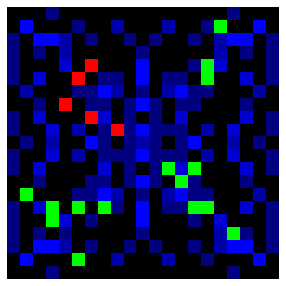

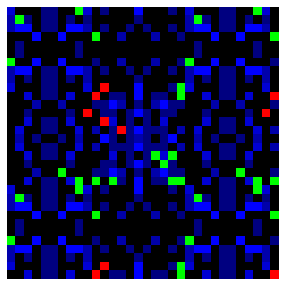

Player:0 ship names: ['2-1', '7-1', '12-1', '15-1', '20-1']
Player:0 shipyard names: ['1-1']


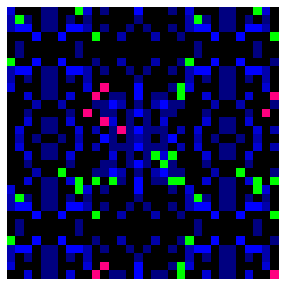

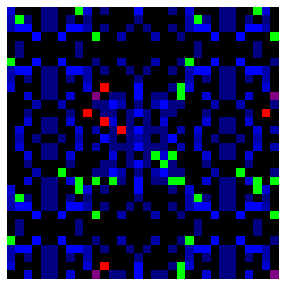

(16, 19)
Player:1 raw map view


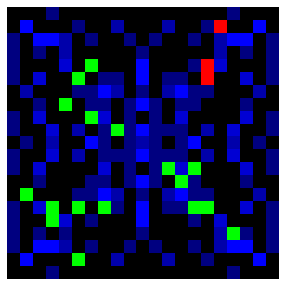

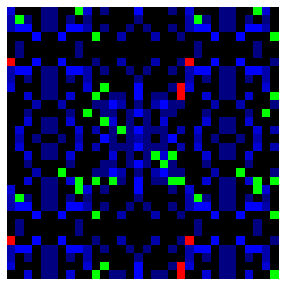

Player:1 ship names: ['9-1', '17-1']
Player:1 shipyard names: ['1-2']


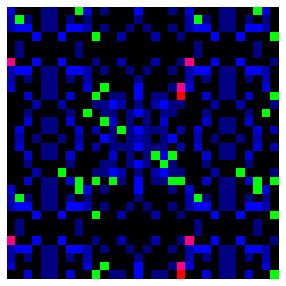

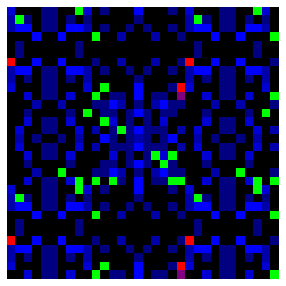

(1, 6)
Player:2 raw map view


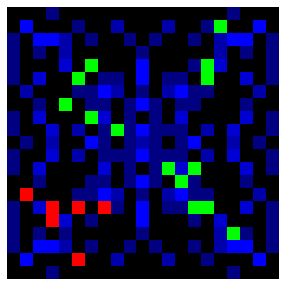

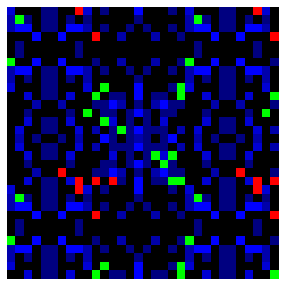

Player:2 ship names: ['3-1', '5-1', '13-1', '15-2', '20-2']
Player:2 shipyard names: ['1-3', '11-1']


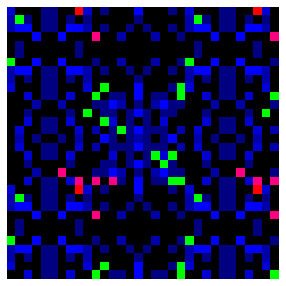

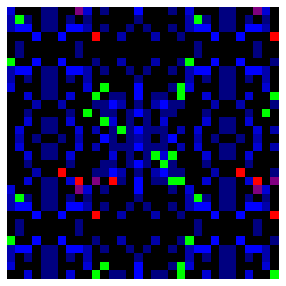

(17, 3)
Player:3 raw map view


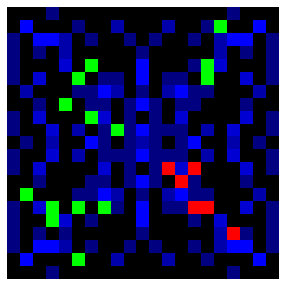

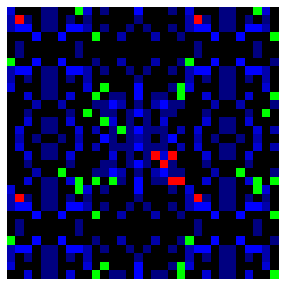

Player:3 ship names: ['7-2', '8-1', '18-1', '19-1']
Player:3 shipyard names: ['1-4', '13-2', '20-3']


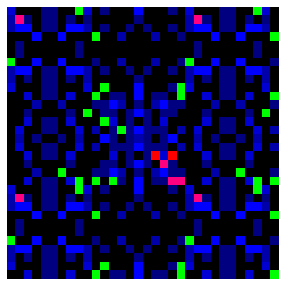

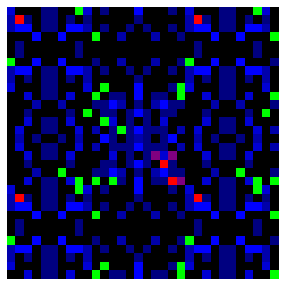

In [28]:
board = Board(obs, env_config)
visualize_obs_for_each_player(board)

In [29]:
# test get_step_frames()
map, ship_obs, shipyard_obs = data_parser.get_step_frames(board, pad=True)

Player:0 map view


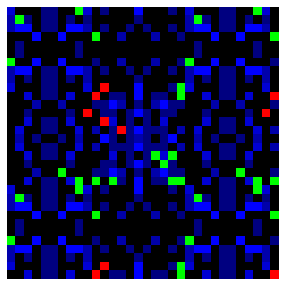

Player:0 ship names: ['2-1', '7-1', '12-1', '15-1', '20-1']


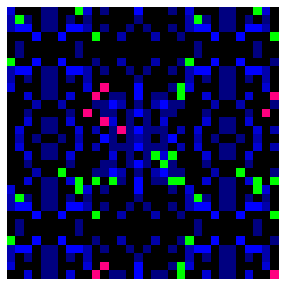

Player:0 shipyard names: ['1-1']


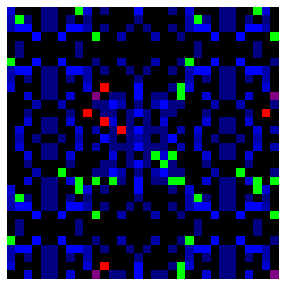

Player:1 map view


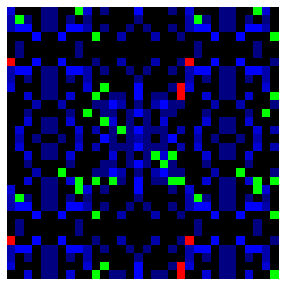

Player:1 ship names: ['9-1', '17-1']


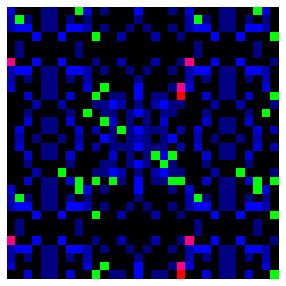

Player:1 shipyard names: ['1-2']


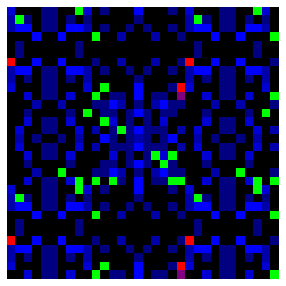

Player:2 map view


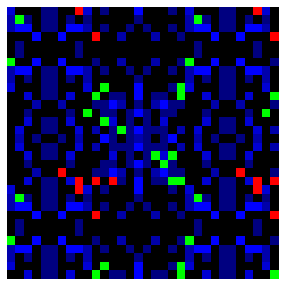

Player:2 ship names: ['3-1', '5-1', '13-1', '15-2', '20-2']


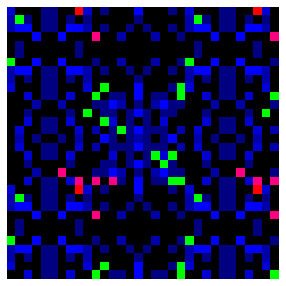

Player:2 shipyard names: ['1-3', '11-1']


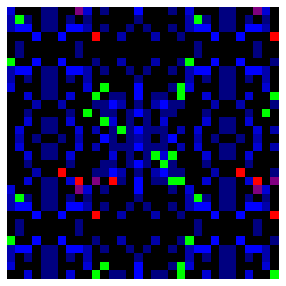

Player:3 map view


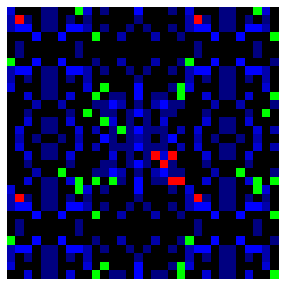

Player:3 ship names: ['7-2', '8-1', '18-1', '19-1']


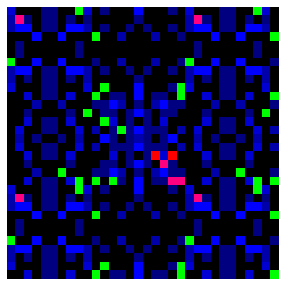

Player:3 shipyard names: ['1-4', '13-2', '20-3']


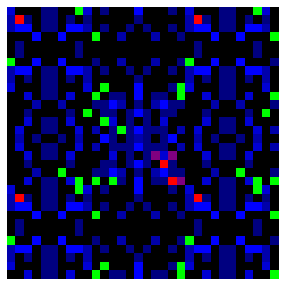

In [30]:
for player_id in range(4):
    print(f'Player:{player_id} map view')
    data_parser.render_map(map[player_id], player_id)
    
    ship_names = board.players[player_id].ship_ids
    print(f'Player:{player_id} ship names: {ship_names}')
    data_parser.render_map(ship_obs[player_id], player_id)
    
    shipyard_names = board.players[player_id].shipyard_ids
    print(f'Player:{player_id} shipyard names: {shipyard_names}')
    data_parser.render_map(shipyard_obs[player_id], player_id)

In [14]:
def make_step(board, env_config, actions):
    obs, reward, done, info = training_env.step(actions)
    board_crt = Board(obs, env_config)

    env.render(mode="ipython", width=600, height=400)
        
    print('Player ship IDs:', ', '.join(board_crt.current_player.ship_ids))
    print('Player shipyard IDs:', ', '.join(board_crt.current_player.shipyard_ids))
    print('Actions:', actions)
    # print('Ship reward list:', get_ship_reward_list(board_prev, actions, board_crt))
    
    return board_crt

In [15]:
make_step(board, env_config, {'0-1': 'CONVERT'})

Player ship IDs: 2-1
Player shipyard IDs: 1-1
Actions: {'0-1': 'CONVERT'}


In [16]:
# test get_player_step_moves
# Try different actions for each ship and check wehther the frames are correct
# Test whether z is correct
# What should happen if there are no ships/shipyards

In [17]:
obs = training_env.reset()
# test with different actions
board = Board(obs, env_config)

# get the names for ships
ship_names = board.ships.keys()
print(ship_names)

env.render(mode="ipython", width=600, height=400)

actions = {}
z, ship_moves, shipyard_moves = data_parser.get_player_step_moves(board,actions, 0)
ship = board.ships['0-1']
print(ship.position)
# print(ship_moves)
assert (ship_moves[20-ship.position.y, ship.position.x] == 5)

actions = {'0-2': 'CONVERT'}
z, ship_moves, shipyard_moves = data_parser.get_player_step_moves(board,actions, 1)
ship = board.ships['0-2']
print(ship.position)
assert (ship_moves[20-ship.position.y, ship.position.x] == 0)
make_step(board, env_config, actions)

dict_keys(['0-1', '0-2', '0-3', '0-4'])


(5, 15)
(15, 15)


Player ship IDs: 0-1
Player shipyard IDs: 
Actions: {'0-2': 'CONVERT'}


In [20]:
env = make("halite", debug=True)
env_config = env.configuration
path = "./data/meta/"

training_env = env.train([None, "random", "random", "random"])
obs = training_env.reset()
board = Board(obs, env_config)
map, ship, shipyard = data_parser.get_step_frames(board, 1, tensor=True)
print(map.shape); print(ship.shape); print(shipyard.shape)

(32, 32, 3)
(32, None, None)
(32, None, None)
